In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fraud = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_map = pd.read_csv("../data/raw/IpAddress_to_Country.csv")



In [2]:
fraud.head()
fraud.info()
fraud.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [3]:
fraud.drop_duplicates(inplace=True)

fraud["signup_time"] = pd.to_datetime(fraud["signup_time"])
fraud["purchase_time"] = pd.to_datetime(fraud["purchase_time"])

fraud["age"].fillna(fraud["age"].median(), inplace=True)
fraud[["source", "browser", "sex"]] = fraud[["source", "browser", "sex"]].fillna("Unknown")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_42092\638425117.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud["age"].fillna(fraud["age"].median(), inplace=True)


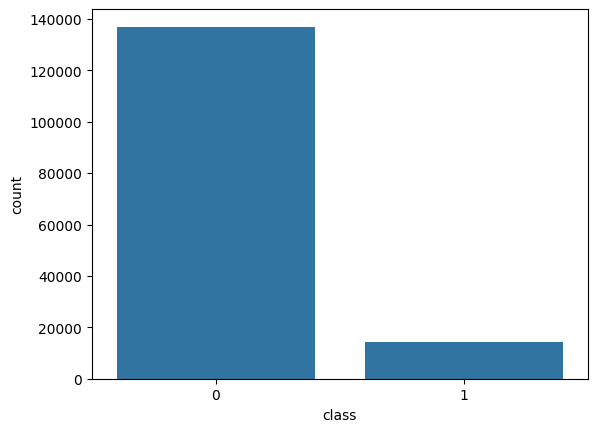

In [4]:
fraud["class"].value_counts(normalize=True)
sns.countplot(x="class", data=fraud)
plt.show()


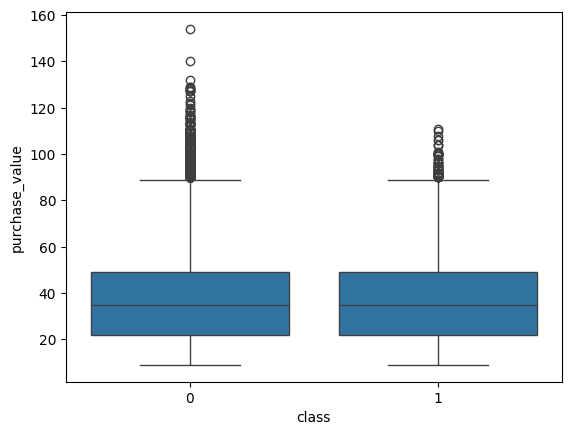

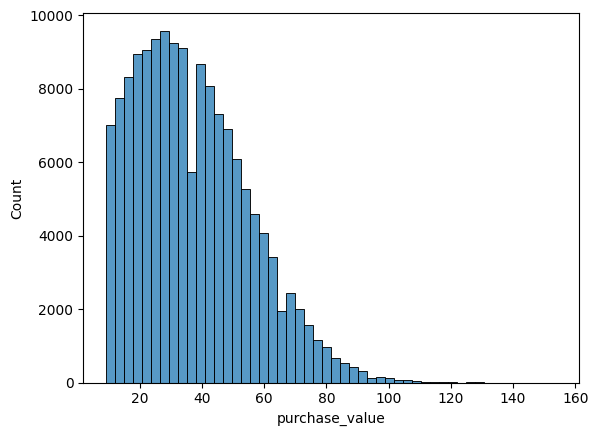

In [5]:
sns.boxplot(x="class", y="purchase_value", data=fraud)
plt.show()

sns.histplot(fraud["purchase_value"], bins=50)
plt.show()


In [6]:
fraud["signup_time"] = pd.to_datetime(fraud["signup_time"])
fraud["purchase_time"] = pd.to_datetime(fraud["purchase_time"])


In [7]:
# numerical: median (robust)
fraud["age"] = fraud["age"].fillna(fraud["age"].median())

# categorical: "Unknown" keeps rows (doesn't drop info)
for c in ["source", "browser", "sex"]:
    fraud[c] = fraud[c].fillna("Unknown")


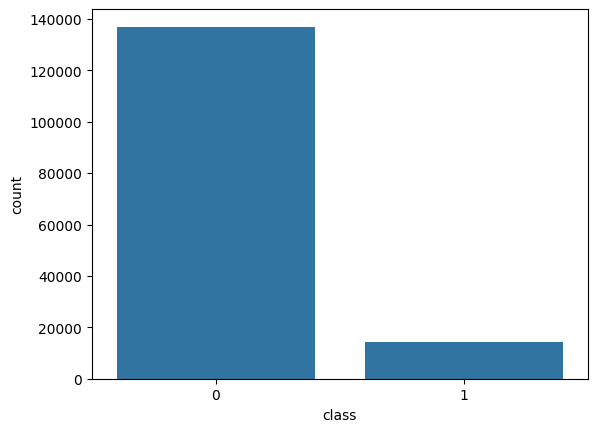

In [8]:
fraud["class"].value_counts()
fraud["class"].value_counts(normalize=True)
sns.countplot(x="class", data=fraud)
plt.show()


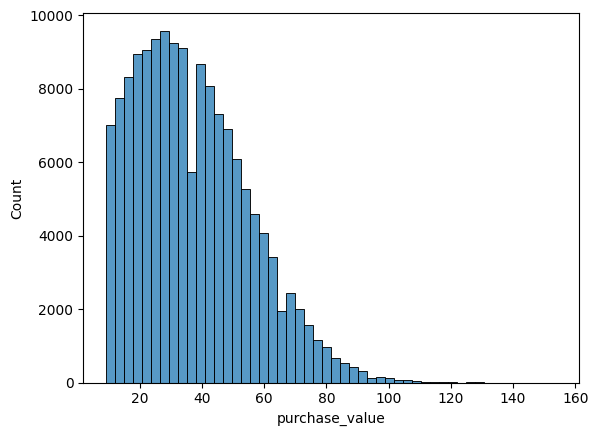

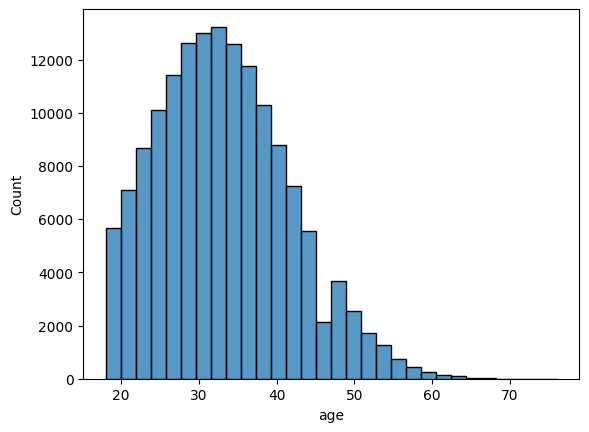

browser
Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: count, dtype: int64

In [9]:
sns.histplot(fraud["purchase_value"], bins=50)
plt.show()

sns.histplot(fraud["age"], bins=30)
plt.show()

fraud["browser"].value_counts().head(10)


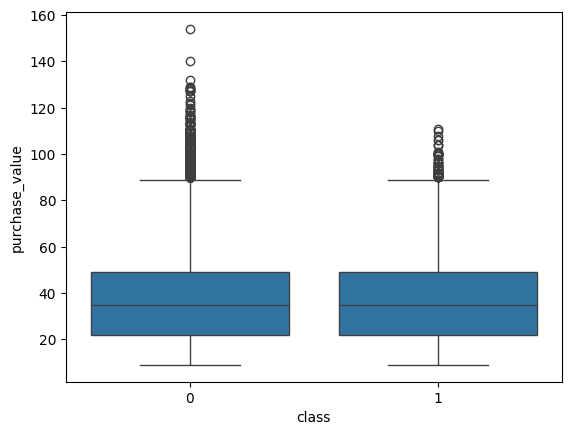

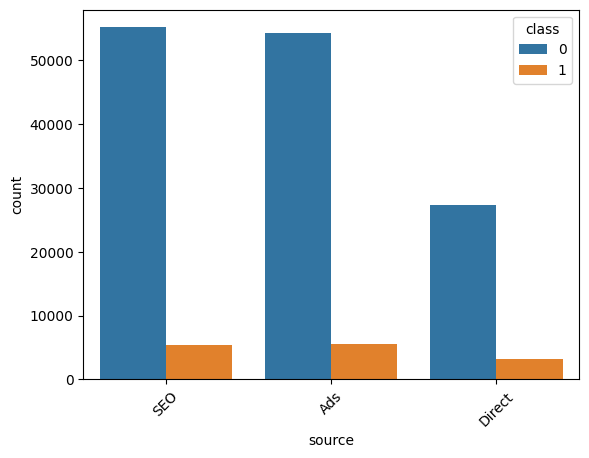

In [10]:
sns.boxplot(x="class", y="purchase_value", data=fraud)
plt.show()

sns.countplot(x="source", hue="class", data=fraud)
plt.xticks(rotation=45)
plt.show()


In [11]:
fraud["ip_int"] = fraud["ip_address"].astype("int64")

ip_map["lower_bound_ip_address"] = ip_map["lower_bound_ip_address"].astype("int64")
ip_map["upper_bound_ip_address"] = ip_map["upper_bound_ip_address"].astype("int64")
ip_map = ip_map.sort_values("lower_bound_ip_address")


In [12]:
fraud = fraud.sort_values("ip_int")

fraud = pd.merge_asof(
    fraud,
    ip_map,
    left_on="ip_int",
    right_on="lower_bound_ip_address",
    direction="backward"
)

fraud["country"] = np.where(
    fraud["ip_int"] <= fraud["upper_bound_ip_address"],
    fraud["country"],
    "Unknown"
)


In [13]:
country_stats = fraud.groupby("country")["class"].agg(["count","mean"]).sort_values("mean", ascending=False)
country_stats.head(10)


,count,mean
country,,
Turkmenistan,1,1.000000
Namibia,23,0.434783
Sri Lanka,31,0.419355
Luxembourg,72,0.388889
Virgin Islands (U.S.),3,0.333333
Ecuador,106,0.264151
Tunisia,118,0.262712
Peru,119,0.260504
Bolivia,53,0.245283


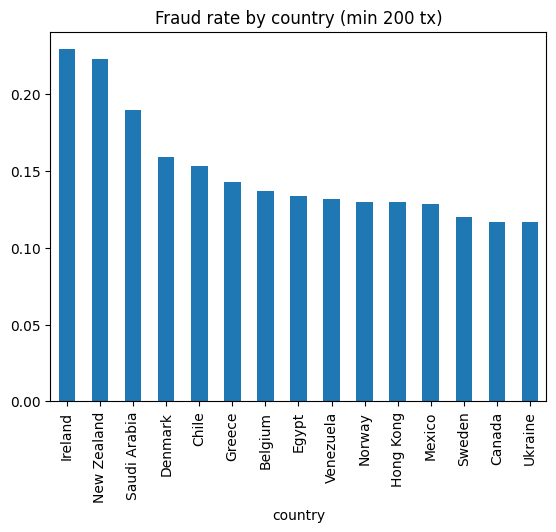

In [14]:
top = country_stats[country_stats["count"] >= 200].head(15)
top["mean"].plot(kind="bar")
plt.title("Fraud rate by country (min 200 tx)")
plt.show()
